In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve

In [10]:
DATA_EDA='data/eda'
DATASET_NAME='digital_marketing_campaign_dataset.csv'

RANDOM_STATE=42

### Loading data

In [11]:
df = pd.read_csv(os.path.join(DATA_EDA,DATASET_NAME))
df.head()

,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
0,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,1
1,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,1
2,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,1
3,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,1
4,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,1


In [12]:
X = df.drop(columns=['Conversion'])
y = df['Conversion']

In [13]:
y.value_counts()

Conversion
1    7012
0     988
Name: count, dtype: int64

### Getting numerical and categorical features

In [14]:
numerical = X.dtypes.index[X.dtypes!='object']
categorical = X.dtypes.index[X.dtypes=='object']

### Splitting data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6400, 16), (6400,), (1600, 16), (1600,))

### Transforming features

In [17]:
one_hot = OneHotEncoder()
standard_scaler = StandardScaler()
preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder', one_hot, categorical),
        ('StandardScaler', standard_scaler, numerical)
    ]
)

In [18]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [19]:
X_train_transformed.shape, X_test_transformed.shape

((6400, 24), (1600, 24))

In [20]:
y

0       1
1       1
2       1
3       1
4       1
       ..
7995    0
7996    0
7997    1
7998    1
7999    0
Name: Conversion, Length: 8000, dtype: int64

### Training models

In [51]:
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_STATE),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_STATE),
    'LGBMClassifier': LGBMClassifier(random_state=RANDOM_STATE, verbosity=0)
}

In [52]:
results = []
for name, model in models.items():
    model.fit(X_train_transformed, y_train)

    y_train_pred = model.predict(X_train_transformed)
    y_test_pred = model.predict(X_test_transformed)

    results.append([name,
                    f1_score(y_train, y_train_pred),
                    f1_score(y_test, y_test_pred)
                    ])

In [53]:
pd.DataFrame(results, columns=['Model name','Train f1 score','Test f1 score'])

,Model name,Train f1 score,Test f1 score
0,RandomForestClassifier,1.000000,0.940781
1,GradientBoostingClassifier,0.967775,0.950786
2,XGBClassifier,1.000000,0.952545
3,LGBMClassifier,0.986460,0.952937


In [54]:
lgbm = LGBMClassifier(random_state=RANDOM_STATE, verbosity=0)
lgbm.fit(X_train_transformed, y_train)

y_train_pred = lgbm.predict(X_train_transformed)
y_train_pred_proba = lgbm.predict_proba(X_train_transformed)[:,1]
y_test_pred = lgbm.predict(X_test_transformed)
y_test_pred_proba = lgbm.predict_proba(X_test_transformed)[:,1]

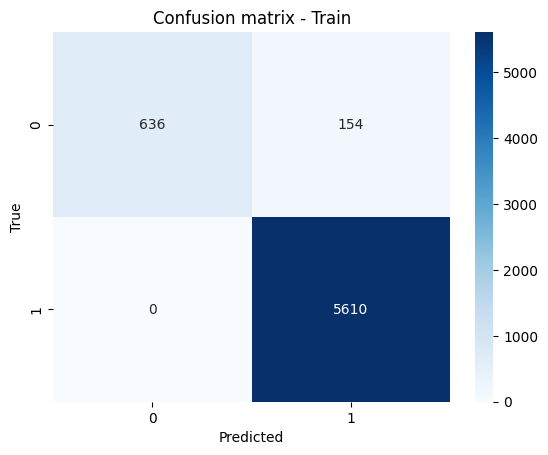

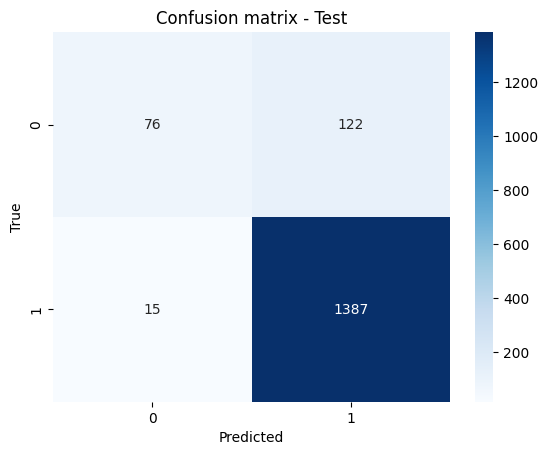

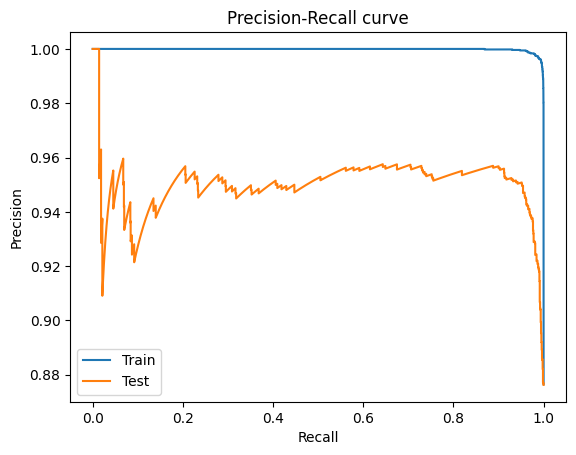

In [55]:
def plot_confusion_matrix(y_true, y_pred, name=None):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix'+(' - '+name if name else ''))
    plt.show()

def plot_precision_recall_curve(y_true, y_pred_proba, y_test, y_test_pred_proba):
    precision_train, recall_train, _ = precision_recall_curve(y_true, y_pred_proba)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)
    plt.plot(recall_train, precision_train, label='Train')
    plt.plot(recall_test, precision_test, label='Test')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend()
    plt.show()

plot_confusion_matrix(y_train, y_train_pred, 'Train')
plot_confusion_matrix(y_test, y_test_pred, 'Test')

plot_precision_recall_curve(y_train, y_train_pred_proba, y_test, y_test_pred_proba)

In [56]:
param_grid = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'n_estimators': [16,32,64,100],
    'num_leaves': [8,12,16,31],
    'boosting_type' : ['gbdt', 'dart'],
    'objective' : ['binary'],
    'colsample_bytree' : [0.5, 0.65, 1],
    'subsample' : [0.7,0.85,1],
    'reg_alpha' : [0,1,1.2],
    'reg_lambda' : [0,1,1.2,1.4],
    'scale_pos_weight' : [0.5,1,1.5]
}

lgbm = LGBMClassifier(random_state=RANDOM_STATE, verbosity=0)
grid_search = RandomizedSearchCV(lgbm, param_grid, n_iter=500, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(estimator=LGBMClassifier(random_state=42, verbosity=0),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'colsample_bytree': [0.5, 0.65, 1],
                                        'learning_rate': [0.005, 0.01, 0.05,
                                                          0.1],
                                        'n_estimators': [16, 32, 64, 100],
                                        'num_leaves': [8, 12, 16, 31],
                                        'objective': ['binary'],
                                        'reg_alpha': [0, 1, 1.2],
                                        'reg_lambda': [0, 1, 1.2, 1.4],
                                        'scale_pos_weight': [0.5, 1, 1.5],
                                        'subsample': [0.7, 0.85, 1]},
                   scoring='f1', verbose=1)

In [57]:
grid_search.best_params_

{'subsample': 0.85,
 'scale_pos_weight': 0.5,
 'reg_lambda': 1.4,
 'reg_alpha': 0,
 'objective': 'binary',
 'num_leaves': 8,
 'n_estimators': 100,
 'learning_rate': 0.1,
 'colsample_bytree': 0.65,
 'boosting_type': 'gbdt'}

Train f1 score: 0.9749781277340333
Test f1 score: 0.9641239986067572


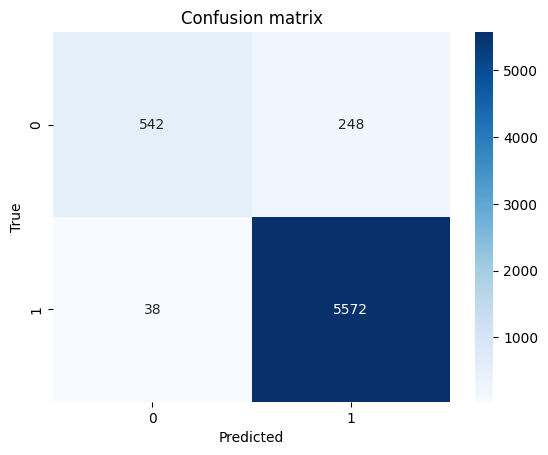

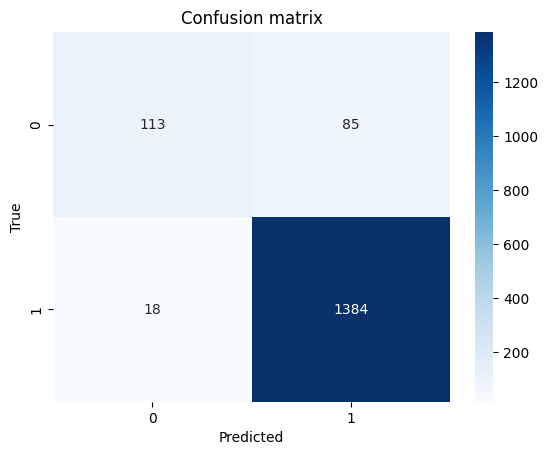

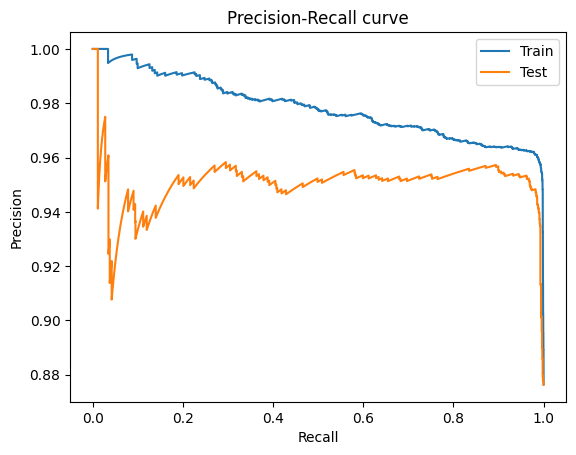

In [58]:
lgbm = LGBMClassifier(random_state=RANDOM_STATE, verbosity=0, **grid_search.best_params_)
lgbm.fit(X_train_transformed, y_train)

y_train_pred = lgbm.predict(X_train_transformed)
y_train_pred_proba = lgbm.predict_proba(X_train_transformed)[:,1]
y_test_pred = lgbm.predict(X_test_transformed)
y_test_pred_proba = lgbm.predict_proba(X_test_transformed)[:,1]

print(f'Train f1 score: {f1_score(y_train, y_train_pred)}')
print(f'Test f1 score: {f1_score(y_test, y_test_pred)}')

plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

plot_precision_recall_curve(y_train, y_train_pred_proba, y_test, y_test_pred_proba)